### Modelling carbon fluxes from wildfire

This example was developed using overmature_decline_and_litterfall.ipynb from the cbm3_scripting_examples repository as a template.

It shows how to stochastically model fire disturbance eventsinitalize a stand with a wildfire disturbance in CBM-CFS3 using cbm3_python.

In [1]:
import os

from scipy.stats import uniform
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pandas as pd
# %matplotlib inline

import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()


from stochastic_disturbance import  get_disturbance_index_for_each_simulation

C:\Users\b_gra\.conda\envs\cbm3\lib\site-packages\cbm3_python\cbm3data\sit_helper.py:27: UserWarning: This method is deprecated, please acquire and install Operational-Scale CBM-CFS3 version 1.2.7606.313 or newer.
  warn(


In [2]:
# Parameters

# These are some of the basic parameters we use for our simulation
# We want one simulation for each Stand in our model.
simulations = 100
# This is the simulation end year
end_age = 270
mean_disturbance_time = 100
# This is the resolution (in years) for our model
step_size = 10

# Seting up the project directory
toolbox_path = 'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
# This is the directory for the project we will create
project_name = 'softwood_stochastic_disturbance_example'
# Let's store our project in the Projects folder of the CBM-CFS3 directory
project_main_path = toolbox_path + '\Projects' + '\\' + project_name
project_path = project_main_path + '\\' + project_name + ".mdb"
results_db_path = project_main_path + '\\' + project_name + '_results.mdb'
config_save_path =  project_main_path + '\\' + 'config.json'

## Create the fire disturbance index for each stand

Here we want to sample from a probability distribution to determine the years
that a particular stand has a fire.  Here we adopt a simple approach using a
uniform probability distribution that can be updated using any standard
probability distribution (e.g. from `scipy.stats`).

Expected average number of disturbances per stand when end_age is 270
2.7
Simulation average number of disturbances per stand when end_age 270
1.94
mean disturbance year: 155.0


(-5.0, 275.0)

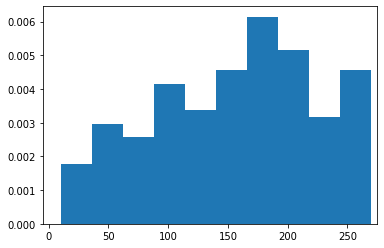

In [3]:
(disturbances_by_simulation,
 all_disturbances) = get_disturbance_index_for_each_simulation(
        simulations,
        mean_disturbance_time,
        end_age,
        step_size)

# Based on the assumptions about the probability of fire, we can compare
# the expected outcomes with the outcome of our Monte Carlo simulation.
print(f'Expected average number of disturbances per stand when end_age is {end_age}')
print(end_age/mean_disturbance_time)
print(f'Simulation average number of disturbances per stand when end_age {end_age}')
print(len(all_disturbances)/simulations)
print(f'mean disturbance year: {np.mean(all_disturbances)}')
    
_, _, _ = plt.hist(all_disturbances, density=True)
plt.xlim(left=-5, right=end_age+5)

In [4]:
disturbances_by_simulation[0:10]

[[10, 40, 100, 260],
 [210, 250],
 [160, 240],
 [90, 120, 130, 220, 260],
 [210],
 [80, 260],
 [90],
 [170, 210],
 [90],
 [210]]

In the histogram we tend to see a positively skewed disturbance distribution.
This is because simulations that have their first disturbance before end_year
also have the potential for a second disturbance event.  Similarly, stands
that have two disturbance events also have a probability of having a third
disturbance before end_year.  This results in a positively skewed probability
distribution for disturbances when we average disturbance results over
multiple simulations.

# Setting up the basic configuration

Here we need to specify the directories that we need to run our model including the location of CBM-CFS3 and teh directories for 



In [5]:
sit_config = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True  # What is this for?
)

### Let's create an object to store the basic configuration requirements for a CBM-CFS3 stand model

In [6]:
sit_config.data_config(
    age_class_size=step_size,
    num_age_classes=int(end_age/step_size),
    # The 'Scenario' classifier is used to specify unique scenario names.
    # classifiers=["Leading Species", "Scenario"])
    classifiers=["Leading Species", "Stand ID"])

sit_config.set_single_spatial_unit(42)
sit_config.set_species_classifier("Leading Species")


# Now we need to define a stand a it's disturbance events

<AxesSubplot:xlabel='age'>

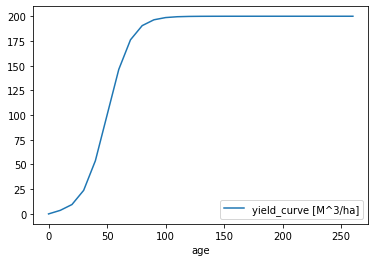

In [7]:
# First we define a yield curve for our stand.  In this example, 10 year time steps is used.
# Each value in the yield curve represents the yield (m3/ha) at 10 year time steps
# starting at year 0.  The data source for this is not clear, but it comes from
# overmature_decline_and_litterfall.ipynb in the cbm3_scripting_examples repo on Github
yield_curve = [
    0.0, 3.597241992, 9.485174636, 23.8405844, 53.78828427, 100, 146.2117157, 176.1594156,
    190.5148254, 196.402758, 198.6614298, 199.5054754, 199.8177898, 199.93293, 199.9753211,
    199.9909204, 199.9966597, 199.9987712, 199.9995479, 199.9998337, 199.9999388, 199.9999775,
    199.9999917, 199.999997, 199.9999989, 199.9999996, 200
  ]
x_axis = [x*10 for x in range(len(yield_curve))]
pd.DataFrame(
    {"age": x_axis,
     "yield_curve [M^3/ha]": yield_curve,
     }) \
    .groupby("age").sum().plot()

## Defining a stand

In [8]:
"""area=1 : a 1 hectare stand.

age=0 .  This looks like the starting point where results are shown.
It's not clear if whether it is valid to start at any year since
the model may need some spin-up time for the DOM pools to
equilibriate.  In Tutorial 1, for example, the model setup seems
to imply that most commont stand replace disturbance and most
recent stand replacing disturbance need to be specified. Defining
an arbitrary age may lead to some discontinuities.

classifier_set : this is used to specify the stand.  In this case,
we are setting the 'Spruce' stand with the 'fire disturbance'.
Note that additional scenarios can be added in the same way by
adding an new combination of 'Leading Species' and 'Scenario'.
Using the same classifier_set combination will overwrite previous
stands.

unfccc_land_class : ?"""

# iteratively adding scenarios
for i in range(len(disturbances_by_simulation)):
    sit_config.add_inventory(
        classifier_set=["Spruce", f"Stand {i+1}"],
        area=1, age=0, unfccc_land_class=0)
    sit_config.add_yield(
        classifier_set=["Spruce", f"Stand {i+1}"],
        leading_species_classifier_value="Spruce",
        values=yield_curve)

## Creating a disturbance event

In [9]:
"""
classifier_set = ["?", "?"] means that the event is applied
to all stands (stands with any value of "Leading Species" and
"Scenario").

disturbance_type : str
    CBM-CFS3 disturbance type
time_step : int
    Year when disturbance occurs.
target : int
    Unclear what the target is.
target_type : str
sort : str
"""
# iteratively add disturbances for each scenario.
for i, disturbance_years in enumerate(disturbances_by_simulation):
    for year in disturbance_years:
        sit_config.add_event(classifier_set=["Spruce", f"Stand {i+1}"], disturbance_type="Wildfire", 
                      time_step=int(year), target=30, target_type="Area", sort="SORT_BY_SW_AGE")

## Running a CBM-CFS3 simulation using the project defined above

In [10]:
import time
start = time.time()

sit_config.import_project(standard_import_tool_plugin_path, config_save_path)

results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path)

stop = time.time()
print(f'simulation time: {(stop-start)/60} minutes')

simulation time: 3.7981690565745034 minutes


## Viewing results from the simulation

In [11]:
pool_results = cbm3_results.load_pool_indicators(results_db_path,classifier_set_grouping=True)


In [12]:
# Here are all the pools that we could inspect
pool_results.columns

Index(['TimeStep', 'UserDefdClassSetID', 'Aboveground Very Fast DOM',
       'Belowground Very Fast DOM', 'Aboveground Fast DOM',
       'Belowground Fast DOM', 'Medium DOM', 'Aboveground Slow DOM',
       'Belowground Slow DOM', 'Softwood Stem Snag', 'Softwood Branch Snag',
       'Hardwood Stem Snag', 'Hardwood Branch Snag', 'BlackCarbon', 'Peat',
       'Softwood Merchantable', 'Softwood Foliage', 'Softwood Other',
       'Softwood Coarse Roots', 'Softwood Fine Roots', 'Hardwood Merchantable',
       'Hardwood Foliage', 'Hardwood Other', 'Hardwood Coarse Roots',
       'Hardwood Fine Roots', 'Total Biomass', 'Aboveground Biomass',
       'Belowground Biomass', 'Total Ecosystem', 'Dead Organic Matter',
       'Aboveground DOM', 'Belowground DOM', 'Deadwood', 'Litter', 'Soil C',
       'Leading Species', 'Stand ID'],
      dtype='object')

<AxesSubplot:title={'center':'Total Biomass'}, xlabel='TimeStep'>

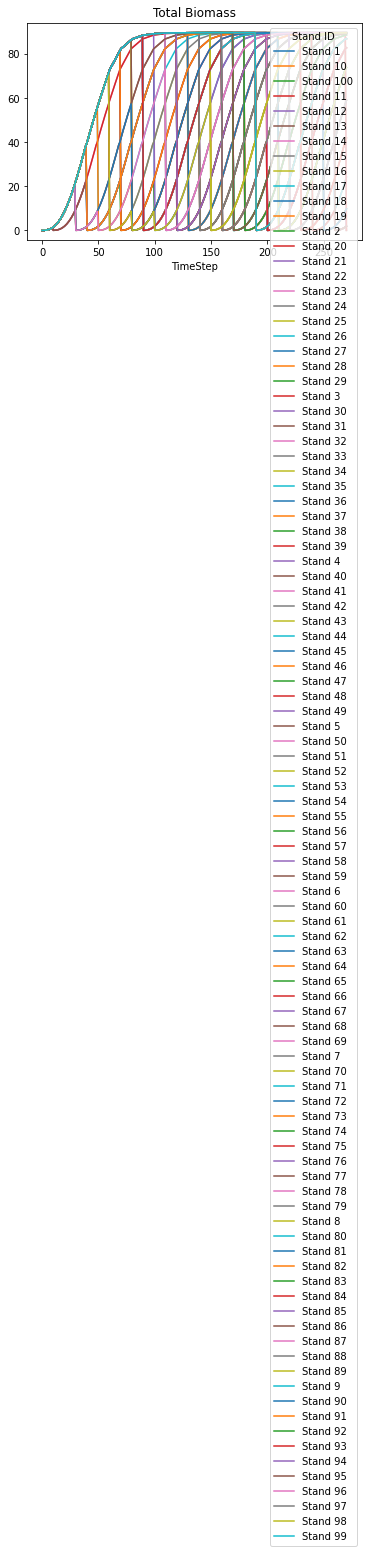

In [13]:
pool_to_plot = "Total Biomass"
pool_results[["TimeStep","Stand ID", pool_to_plot]] \
    .pivot(index="TimeStep", columns="Stand ID", values=pool_to_plot) \
    .plot(title=pool_to_plot)

<AxesSubplot:title={'center':'mean Total Biomass'}, xlabel='TimeStep'>

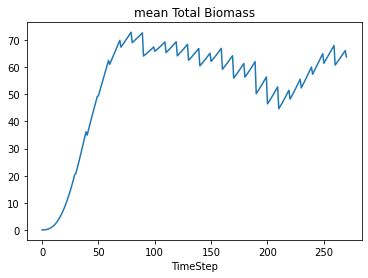

In [14]:
pools_to_plot = pool_results[["TimeStep","Stand ID", pool_to_plot]]
pools_to_plot = pools_to_plot.pivot(index="TimeStep", columns="Stand ID", values=pool_to_plot)
pools_to_plot.mean(axis=1).plot(title=f'mean {pool_to_plot}')

In [15]:
stock_change_results = cbm3_results.load_stock_changes(results_db_path, classifier_set_grouping=True)

In [16]:
# And here are the stock change results we could explore
stock_change_results.columns

Index(['TimeStep', 'UserDefdClassSetID', 'Delta Total Ecosystem',
       'Delta Total Biomass', 'Delta Total DOM',
       'Net Primary Productivity (NPP)', 'Net Ecosystem Productivity (NEP)',
       'Net Growth', 'Net Litterfall', 'Total Litterfall',
       'Decomposition Releases', 'NetCO2emissions_removals_CO2e',
       'SumofCOProduction_CO2e', 'SumofCH4Production_CO2e', 'N2O_CO2e',
       'ToFps_CO2e', 'Total Harvest (Biomass + Snags)',
       'Total Harvest (Biomass)', 'Total Harvest (Snags)',
       'Softwood Harvest (Biomass)', 'Hardwood Harvest (Biomass)', 'Deadwood',
       'Litter', 'Soil C', 'Aboveground Very Fast DOM Emissions',
       'Belowground Very Fast DOM Emissions', 'Aboveground Fast DOM Emissions',
       'Belowground Fast DOM Emissions', 'Medium DOM Emissions',
       'Aboveground Slow DOM Emissions', 'Belowground Slow DOM Emissions',
       'Softwood Stem Snag Emissions', 'Softwood Branch Snag Emissions',
       'Hardwood Stem Snag Emissions', 'Hardwood Branch Sn

<AxesSubplot:title={'center':'Net Ecosystem Productivity (NEP)'}, xlabel='TimeStep'>

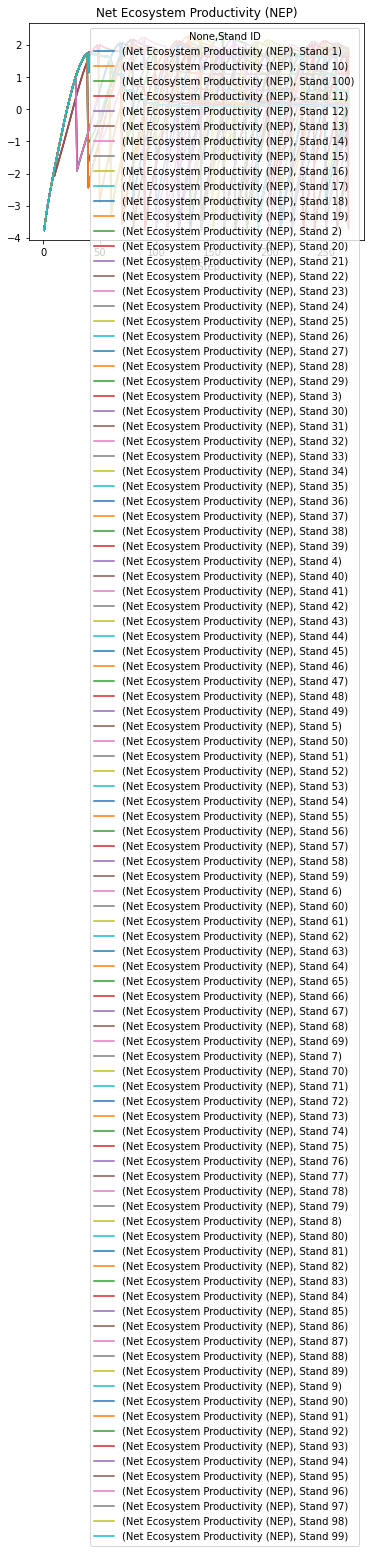

In [17]:
stock_to_plot = 'Net Ecosystem Productivity (NEP)'
stock_change_results[["TimeStep","Stand ID", stock_to_plot]] \
    .pivot(index="TimeStep", columns="Stand ID", values=[stock_to_plot]) \
    .plot(title=stock_to_plot)

<AxesSubplot:title={'center':'mean Net Ecosystem Productivity (NEP)'}, xlabel='TimeStep'>

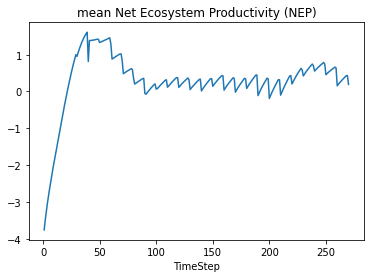

In [18]:
to_plot = stock_change_results[["TimeStep","Stand ID", stock_to_plot]]
to_plot = to_plot.pivot(index="TimeStep", columns="Stand ID", values=stock_to_plot)
to_plot.mean(axis=1).plot(title=f'mean {stock_to_plot}')

In [19]:
to_plot.mean().mean()

0.29572997188272176

In [20]:
def mean_stand_plot(results, y, x):
    to_plot = stock_change_results[["TimeStep","Stand ID", stock_to_plot]]
    to_plot = to_plot.pivot(index="TimeStep", columns="Stand ID", values=stock_to_plot)
    to_plot.mean(axis=1).plot(title=f'mean {stock_to_plot}')